In [234]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from tqdm import tqdm

In [133]:
zebra_path = '../images/zebra.jpg'
image = imageio.imread(zebra_path).astype(np.uint8)

In [134]:
image = (255*resize(image, (image.shape[0]//4, image.shape[1]//4))).astype(np.uint8)

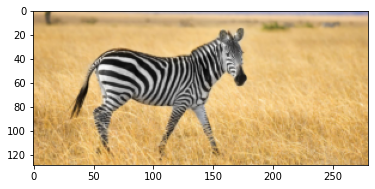

In [135]:
plt.imshow(image)

In [136]:
filtered = 1 - (image.min(axis=2) < 160) * (image.max(axis=2) > 180)

mask = np.zeros(image.shape).astype(int)
entry_point = (60, 100)

to_visit = [entry_point]
seen = {entry_point}

while len(to_visit) > 0:
    p = to_visit.pop()
    mask[p] = 1
    right = (p[0], p[1]+1)
    left = (p[0], p[1]-1)
    up = (p[0]+1, p[1])
    down = (p[0]-1, p[1])
    for ngh in [right, left, up, down]:
        if (not ngh in seen) and filtered[ngh]:
            to_visit.append(ngh)
            seen.add(ngh)

In [137]:
target = image*(1-mask)

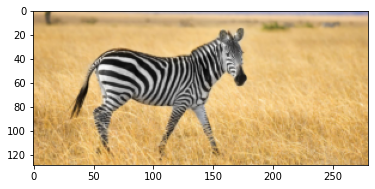

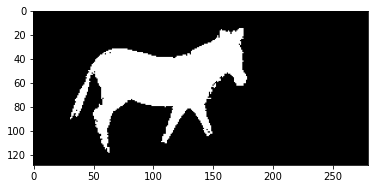

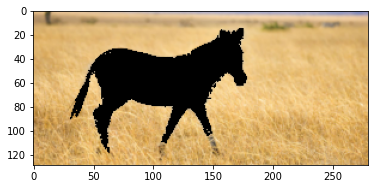

In [138]:
plt.imshow(image)
plt.show()
plt.imshow(255*mask)
plt.show()
plt.imshow(target)
plt.show()

In [301]:
w, h = 8, 8
gap_x, gap_y = w//2, h//2

In [302]:
def extract_patch(img, p):
    return img[p[0]-gap_y:p[0]+gap_y, p[1]-gap_x:p[1]+gap_x]

In [303]:
def apply_path(img, p, patch):
    img[p[0]-gap_y:p[0]+gap_y, p[1]-gap_x:p[1]+gap_x] = patch

In [304]:
def Vp(p, x):
    patch_p = extract_patch(image, p)
    patch_x = extract_patch(image, x)
    patch_mask = extract_patch(mask, p)
    return (patch_mask*(patch_p - patch_x)**2).sum()

In [305]:
def Vpq(p, q, xp, xq):
    image_p = np.zeros(image.shape)
    apply_path(image_p, p, extract_patch(image, p))
    image_q = np.zeros(image.shape)
    apply_path(image_q, q, extract_patch(image, q))
    
    return ((mask * image_p * image_q)**2).sum()

In [306]:
labels = list(zip(np.random.randint(0, image.shape[0], 10), np.random.randint(0, image.shape[1], 10)))

In [307]:
nodes, edges = [], []

for i in range(gap_y, image.shape[0], gap_y):
    for j in range(gap_x, image.shape[1], gap_x):
        try:
            if mask[i,j,0] or mask[i+gap_x,j+gap_y,0] or mask[i+gap_x,j-gap_y,0] or mask[i-gap_x,j+gap_y,0] or mask[i-gap_x,j-gap_y,0]:
                nodes.append((i, j))
        except:
            pass

def are_ngh(i, j):
    node1, node2 = nodes[i], nodes[j]
    if node1[0] == node2[0]:
        return np.abs(node1[1] - node2[1]) <= gap_y
    if node1[1] == node2[1]:
        return np.abs(node1[0] - node2[0]) <= gap_x
    return False
            
for i in range(len(nodes)):
    for j in range(i+1, len(nodes)):
        if are_ngh(i,j):
            edges.append((i, j))
            edges.append((j, i))

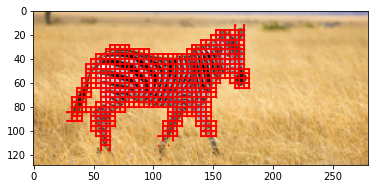

In [308]:
# Show edges and nodes

img = image.copy()
plt.imshow(img)

for node in nodes:
    plt.scatter(node[1], node[0], c='r', s=0.5)
    
for i, j in edges:
    plt.plot([nodes[i][1], nodes[j][1]], [nodes[i][0], nodes[j][0]], 'r-')
    
plt.show()

In [309]:
def F(x):
    f = sum([Vp(nodes[i], labels[x[i]]) for i in range(len(nodes))])
    for i, j in edges:
        f += Vpq(nodes[i], nodes[j], labels[x[i]], labels[x[j]])
    return f

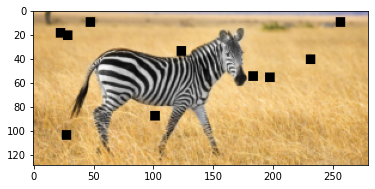

In [310]:
# Show labels

img = image.copy()
for p in labels:
    img[p[0]-gap_y:p[0]+gap_y, p[1]-gap_x:p[1]+gap_x] = 0

plt.imshow(img)
plt.show()

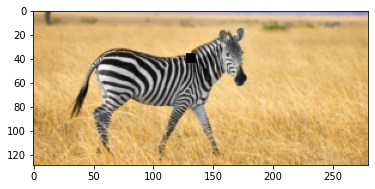

In [311]:
img = image.copy()

p = nodes[120]
img[p[0]-gap_y:p[0]+gap_y, p[1]-gap_x:p[1]+gap_x] = 0

plt.imshow(img)
plt.show()

In [312]:
n_edges = len(edges)
n_labels = len(labels)
n_nodes = len(nodes)

In [313]:
messages = np.zeros((n_edges, n_labels))
n_iter = 2

for iteration in range(n_iter):
    print(f"Iteration {iteration}")
    messages_update = np.zeros(messages.shape)
    for k, (i, j) in enumerate(tqdm(edges)):
        p, q = nodes[i], nodes[j]
        for i_label, xq in enumerate(labels): 
            messages_update[k][i_label] = min([Vp(p, xp) + Vpq(p, q, xp, xq) + sum([messages[i_edge, i_label] for i_edge, (_, j) in enumerate(edges) if j == i_node]) for xp in labels])
    messages = messages_update

  0%|          | 2/2102 [00:00<02:33, 13.68it/s]

Iteration 0


  0%|          | 3/2102 [00:00<01:35, 22.00it/s]

Iteration 1


100%|██████████| 2102/2102 [01:35<00:00, 21.95it/s]


In [314]:
beliefs = np.zeros((n_nodes, n_labels))

In [315]:
for i_node, p in enumerate(nodes):
    for i_label, xp in enumerate(labels):
        beliefs[i_node][i_label] = - Vp(p, xp) - sum([messages[i_edge, i_label] for i_edge, (_, j) in enumerate(edges) if j == i_node])

In [316]:
x_hat = np.argmax(beliefs, axis=1)

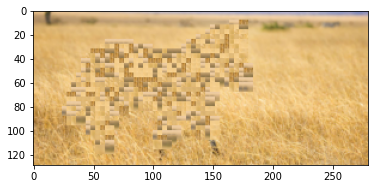

In [317]:
res = target.copy()
for i_node, i_label in enumerate(x_hat):
    apply_path(res, nodes[i_node], extract_patch(image, labels[i_label]))
plt.imshow(res)
plt.show()